## **Cleaning Weather datasets**

In [25]:
import pandas as pd

In [26]:

weather_data_csv = 'datasets/weatherAUS.csv'
processed_data_csv = 'datasets/processed_weatherAUS.csv'

# weather_data = pd.read_csv(weather_data_csv)
processed_data = pd.read_csv(processed_data_csv)

# print(weather_data.columns.tolist())

# weather_data.drop(columns=['Evaporation',
#                            'WindGustDir',
#                            'WindGustSpeed',
#                            'WindDir9am',
#                            'WindDir3pm',
#                            'Temp9am',
#                            'Temp3pm',
#                            'RainToday',
#                            'RainTomorrow'], inplace=True)

processed_data['Location'].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

### **Reading the flu file**

In [27]:
flu_path = 'datasets/people_per_date.csv'

flu_data = pd.read_csv(flu_path)

# Convert the data column into datetime format
processed_data['Date'] = pd.to_datetime(processed_data['Date'])

# Create yearweek column (the numbered week in the year)
processed_data['Year_Week'] = processed_data['Date'].dt.strftime('%Y-%U')
flu_data['Week Ending (Friday)'] = pd.to_datetime(flu_data['Week Ending (Friday)'])
flu_data['Year_Week'] = flu_data['Week Ending (Friday)'].dt.strftime('%Y-%U')

flu_data['Daily_Flu_Cases'] = flu_data['Number of Sick People'] / 7

# merging the flu dataset with the weather dataset
merged_data = pd.merge(processed_data, flu_data[['Year_Week', 'Daily_Flu_Cases']], on='Year_Week', how='left')

merged_data

,Date,Location,MinTemp,MaxTemp,Rainfall,HumidityAve,WindSpeedAve,PressureAve,CloudAve,WindGustSpeed,Year_Week,Daily_Flu_Cases
0,2008-12-01,Albury,13.4,22.9,0.6,46.5,22.0,1007.40,NaN,44.0,2008-48,8.428571
1,2008-12-02,Albury,7.4,25.1,0.0,34.5,13.0,1009.20,NaN,44.0,2008-48,8.428571
2,2008-12-03,Albury,12.9,25.7,0.0,34.0,22.5,1008.15,NaN,46.0,2008-48,8.428571
3,2008-12-04,Albury,9.2,28.0,0.0,30.5,10.0,1015.20,NaN,24.0,2008-48,8.428571
4,2008-12-05,Albury,17.5,32.3,1.0,57.5,13.5,1008.40,7.5,41.0,2008-48,8.428571
...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,37.5,12.0,1022.45,NaN,31.0,2017-25,299.142857
145456,2017-06-22,Uluru,3.6,25.3,0.0,38.5,11.0,1021.30,NaN,22.0,2017-25,299.142857
145457,2017-06-23,Uluru,5.4,26.9,0.0,38.5,9.0,1018.90,NaN,37.0,2017-25,299.142857
145458,2017-06-24,Uluru,7.8,27.0,0.0,37.5,10.0,1017.95,2.5,28.0,2017-25,299.142857


In [28]:
# Apply fillna() on multiple columns at once using a dictionary
merged_data.fillna({
    'MinTemp': merged_data['MinTemp'].mean(),
    'MaxTemp': merged_data['MaxTemp'].mean(),
    'Rainfall': merged_data['Rainfall'].mean(),
    'HumidityAve': merged_data['HumidityAve'].mean(),
    'CloudAve': merged_data['CloudAve'].bfill(),
    'PressureAve': merged_data['PressureAve'].mean(),
    'Daily_Flu_Cases': merged_data['Daily_Flu_Cases'].mean(),
}, inplace=True)

## **Cleaning The DataSet**

## **Training Weather and Dumping its pkl files**

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pickle

# ensure 'Date' is in datetime format
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Create 'DayOfYear' and 'DayOfWeek' features
merged_data['DayOfYear'] = merged_data['Date'].dt.dayofyear
merged_data['DayOfWeek'] = merged_data['Date'].dt.dayofweek

# Create 'ChanceOfRain' based on 'Rainfall'
merged_data['ChanceOfRain'] = np.where(merged_data['Rainfall'] > 3.3, 1, 0)

# List to store each location's model file paths
model_paths = []

# splitting the dataset by location
locations = merged_data['Location'].unique()

for location in locations:
    # filter data for the current location
    location_data = merged_data[merged_data['Location'] == location]

    # Selecting the features for temperature and rain prediction
    features = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindSpeedAve', 'HumidityAve', 'PressureAve', 
                'CloudAve', 'Daily_Flu_Cases', 'DayOfYear', 'DayOfWeek']

    X = location_data[features]
    y_min_temp = location_data['MinTemp']
    y_max_temp = location_data['MaxTemp']
    y_rain = location_data['ChanceOfRain']

    # Using imputer to handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Standardizing the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # Split the data into training and testing sets
    X_train_temp, X_test_temp, y_train_min_temp, y_test_min_temp, y_train_max_temp, y_test_max_temp = train_test_split(
        X_scaled, y_min_temp, y_max_temp, test_size=0.3, random_state=42
    )

    X_train_rain, X_test_rain, y_train_rain, y_test_rain = train_test_split(
        X_scaled, y_rain, test_size=0.3, random_state=42
    )

    # Train separate models for each location

    # Linear Regression for MinTemp and MaxTemp
    min_temp_model = LinearRegression()
    max_temp_model = LinearRegression()
    humidity_model = LinearRegression()

    min_temp_model.fit(X_train_temp, y_train_min_temp)
    max_temp_model.fit(X_train_temp, y_train_max_temp)
    humidity_model.fit(X_train_rain, y_train_rain)
    
    y_min_temp_pred = min_temp_model.predict(X_test_temp) 
    y_max_temp_pred = max_temp_model.predict(X_test_temp)

    # Random Forest Classifier for ChanceOfRain
    rain_model = RandomForestClassifier(random_state=42, class_weight='balanced')
    rain_model.fit(X_train_rain, y_train_rain)
    
    y_rain_pred = rain_model.predict(X_test_rain)

    #  Save each model to a .pkl file

    # # Save models for the current location
    # min_temp_model_file = f'min_temp_model_{location}.pkl'
    # max_temp_model_file = f'max_temp_model_{location}.pkl'
    # rain_model_file = f'rain_model_{location}.pkl'
    # scaler_file = f'model_scaler_{location}.pkl'
    
    # with open(min_temp_model_file, 'wb') as f:
    #     pickle.dump(min_temp_model, f)
    
    # with open(max_temp_model_file, 'wb') as f:
    #     pickle.dump(max_temp_model, f)
    
    # with open(rain_model_file, 'wb') as f:
    #     pickle.dump(rain_model, f)

    # with open(scaler_file, 'wb') as f:
    #     pickle.dump(scaler, f)
    
    # # Append model file paths to the list
    # model_paths.append({
    #     'location': location,
    #     'min_temp_model': min_temp_model_file,
    #     'max_temp_model': max_temp_model_file,
    #     'rain_model': rain_model_file,
    #     'scaler_file': scaler_file
    # })

# Output model paths
for model_info in model_paths:
    print(f"Models for {model_info['location']}:")
    print(f"Min Temp Model: {model_info['min_temp_model']}")
    print(f"Max Temp Model: {model_info['max_temp_model']}")
    print(f"Rain Model: {model_info['rain_model']}")

print(len(model_paths))


0


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report

mae_min = mean_absolute_error(y_test_min_temp, y_min_temp_pred)
mae_max = mean_absolute_error(y_test_max_temp, y_max_temp_pred)

mse_min = mean_squared_error(y_test_min_temp, y_min_temp_pred)
mse_max = mean_squared_error(y_test_max_temp, y_max_temp_pred)

r2_min = r2_score(y_test_min_temp, y_min_temp_pred)
r2_max = r2_score(y_test_max_temp, y_max_temp_pred)

print(f"Min temperature Mean Absolute Error: {mae_min}")
print(f"Max temperatureMean Absolute Error: {mae_max} \n")

print(f"Min temperature Mean Square Error: {mse_min}")
print(f"Max temperature Mean Square Error: {mse_max} \n")

print(f"Min temperature R2 Score: {r2_min}")
print(f"Max temperature R2 Score: {r2_max} \n")

print(f"Classification report: {classification_report(y_test_rain, y_rain_pred)}")



Min temperature Mean Absolute Error: 5.391784065636065e-15
Max temperatureMean Absolute Error: 2.1098921953213946e-15 

Min temperature Mean Square Error: 4.846956361047018e-29
Max temperature Mean Square Error: 1.4345951483133167e-29 

Min temperature R2 Score: 1.0
Max temperature R2 Score: 1.0 

Classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00        18

    accuracy                           1.00       474
   macro avg       1.00      1.00      1.00       474
weighted avg       1.00      1.00      1.00       474



In [31]:
merged_data.to_csv('merged_data.csv', index=False)

## **Outputting the predictions**

In [32]:
import numpy as np
import pandas as pd
import pickle

# Function to load models based on location
def load_location_models(location):
    min_temp_model_file = f'trained_model/min_temp_model_{location}.pkl'
    max_temp_model_file = f'trained_model/max_temp_model_{location}.pkl'
    rain_model_file = f'trained_model/rain_model_{location}.pkl'

    with open(min_temp_model_file, 'rb') as file:
        min_temp_model = pickle.load(file)
        
    with open(max_temp_model_file, 'rb') as file:
        max_temp_model = pickle.load(file)
        
    with open(rain_model_file, 'rb') as file:
        rain_model = pickle.load(file)

    
    return min_temp_model, max_temp_model, rain_model

# Example location for prediction
location = 'Melbourne'  # Replace with desired location

# Load models for the specified location
min_temp_model, max_temp_model, rain_model = load_location_models(location)


# Prepare future date features
future_dates = pd.date_range(start='2024-9-23', periods=7, freq='D')
future_data = pd.DataFrame(future_dates, columns=['Date'])
future_data['DayOfYear'] = future_data['Date'].dt.dayofyear
future_data['DayOfWeek'] = future_data['Date'].dt.dayofweek

# Get historical averages for relevant features
historical_averages = merged_data.groupby('DayOfYear').agg({
    'MinTemp': 'mean',
    'MaxTemp': 'mean',
    'Rainfall': 'mean',
    'WindSpeedAve': 'mean',
    'HumidityAve': 'mean',
    'PressureAve': 'mean',
    'CloudAve': 'mean',
    'Daily_Flu_Cases': 'mean'
}).reset_index()

# Merge the historical averages with the future date features
future_data = future_data.merge(historical_averages, on='DayOfYear', how='left')

# Scale the features for future dates (convert to NumPy array to avoid feature names warning)
X_future = future_data[['MinTemp', 'MaxTemp', 'Rainfall', 'WindSpeedAve', 'HumidityAve', 'PressureAve', 'CloudAve', 'Daily_Flu_Cases', 'DayOfYear', 'DayOfWeek']].values  # Convert to NumPy array

# Apply the scaling (use the location-specific scaler from training)
X_future_scaled = scaler.transform(X_future)

# Predict ChanceOfRain using the trained Random Forest model
y_future_rain_prob = rain_model.predict_proba(X_future_scaled)[:, 1]  # Probability of rain (class 1)

# Convert probabilities to percentages and clip values to a valid range
future_data['Predicted_ChanceOfRain'] = np.clip(y_future_rain_prob * 100, 0, 100)  # Convert to percentage

# Predict MinTemp and MaxTemp using the trained Linear Regression models
future_data['Predicted_Min_Temp'] = min_temp_model.predict(X_future_scaled)
future_data['Predicted_Max_Temp'] = max_temp_model.predict(X_future_scaled)
future_data['Predicted_Rain'] = rain_model.predict(X_future_scaled)

# Display the predictions in the desired format
predictions_output = future_data[['Date', 'Predicted_Min_Temp', 'Predicted_Max_Temp', 'Predicted_ChanceOfRain', 'Rainfall']]
print(f"\nPredictions for future dates at {location}:")
print(predictions_output)



Predictions for future dates at Melbourne:
        Date  Predicted_Min_Temp  Predicted_Max_Temp  Predicted_ChanceOfRain  \
0 2024-09-23            9.588005           14.528873                     0.0   
1 2024-09-24            9.531679           14.388813                    89.0   
2 2024-09-25            9.303901           14.090707                    98.0   
3 2024-09-26            9.211739           14.693807                     0.0   
4 2024-09-27            9.535896           15.007302                     2.0   
5 2024-09-28            9.533444           14.614866                    96.0   
6 2024-09-29            9.547825           14.665106                    94.0   

   Rainfall  
0  0.768480  
1  2.214042  
2  2.894813  
3  1.251816  
4  1.488369  
5  2.779393  
6  2.300841  


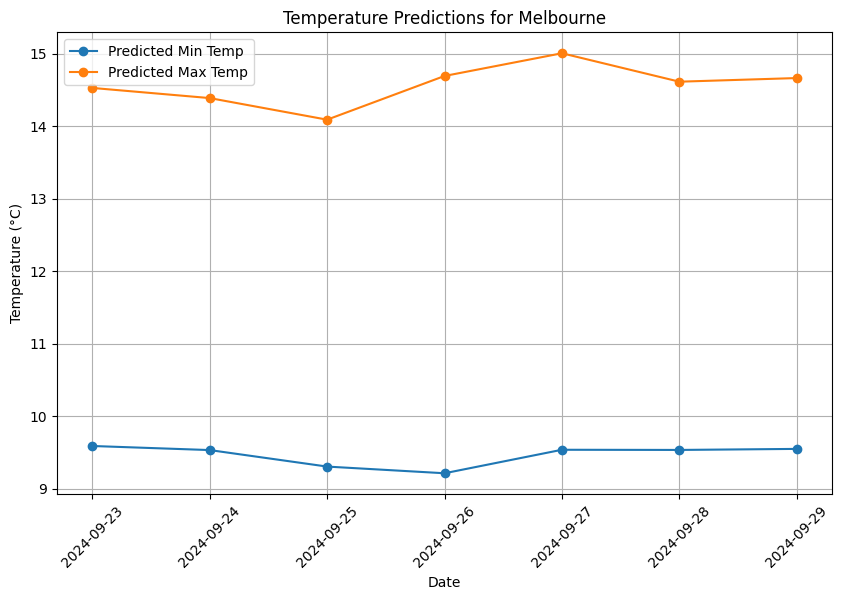

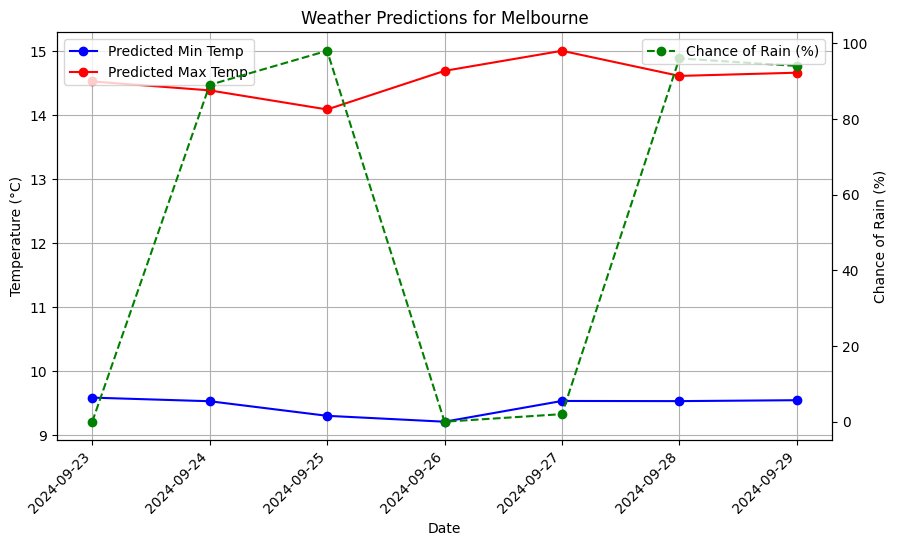

In [33]:
import matplotlib.pyplot as plt

# Set the date as the index for easier plotting
future_data.set_index('Date', inplace=True)

# Plot Predicted Minimum and Maximum Temperature
plt.figure(figsize=(10, 6))
plt.plot(future_data.index, future_data['Predicted_Min_Temp'], label='Predicted Min Temp', marker='o')
plt.plot(future_data.index, future_data['Predicted_Max_Temp'], label='Predicted Max Temp', marker='o')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Predictions for {location}')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot Chance of Rain Prediction
fig, ax1 = plt.subplots(figsize=(10, 6))

# Temperature lines
ax1.plot(future_data.index, future_data['Predicted_Min_Temp'], label='Predicted Min Temp', color='blue', marker='o')
ax1.plot(future_data.index, future_data['Predicted_Max_Temp'], label='Predicted Max Temp', color='red', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title(f'Weather Predictions for {location}')
ax1.legend(loc='upper left')
ax1.grid(True)

# Chance of Rain line on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(future_data.index, future_data['Predicted_ChanceOfRain'], label='Chance of Rain (%)', color='green', marker='o', linestyle='--')
ax2.set_ylabel('Chance of Rain (%)')
ax2.legend(loc='upper right')

fig.autofmt_xdate(rotation=45)
plt.show()


In [34]:
# Check for class imbalance in ChanceOfRain
print(merged_data['ChanceOfRain'].value_counts(normalize=True))


ChanceOfRain
0    0.857301
1    0.142699
Name: proportion, dtype: float64


## **TRAINING FLU**

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report

# Preprocess the dataset: Drop rows with missing values
df_cleaned = merged_data.dropna()

# Feature selection for flu prediction
X_flu = df_cleaned[['MinTemp', 'MaxTemp', 'Rainfall', 'WindSpeedAve', 'HumidityAve', 'PressureAve', 'CloudAve', 'DayOfYear', 'DayOfWeek']]
y_flu = df_cleaned['Daily_Flu_Cases']

# Split the dataset into training and testing sets
X_train_flu, X_test_flu, y_train_flu, y_test_flu = train_test_split(X_flu, y_flu, test_size=0.2, random_state=42)

# Initialize the Linear Regression model for flu prediction
flu_model_lr = LinearRegression()

# Train the model on the training set
flu_model_lr.fit(X_train_flu, y_train_flu)

# Make predictions on the test set
y_pred_flu_lr = flu_model_lr.predict(X_test_flu)

# Evaluate the model's performance
mse_flu_lr = mean_squared_error(y_test_flu, y_pred_flu_lr)
r2_flu_lr = r2_score(y_test_flu, y_pred_flu_lr)

print(f"Mean Squared Error: {mse_flu_lr}")
print(f"R-squared: {r2_flu_lr}")

# Future dates for prediction
future_dates = pd.date_range(start='2024-3-01', periods=7, freq='D')

# Create a DataFrame for future dates
future_data = pd.DataFrame(future_dates, columns=['Date'])
future_data['DayOfYear'] = future_data['Date'].dt.dayofyear
future_data['DayOfWeek'] = future_data['Date'].dt.dayofweek

# Use historical averages for weather data
historical_averages = df_cleaned.groupby('DayOfYear').agg({
    'MinTemp': 'mean',
    'MaxTemp': 'mean',
    'Rainfall': 'mean',
    'WindSpeedAve': 'mean',
    'HumidityAve': 'mean',
    'PressureAve': 'mean',
    'CloudAve': 'mean'
}).reset_index()

# Merge the historical averages with the future date features
future_data = future_data.merge(historical_averages, on='DayOfYear', how='left')

# Select features for prediction (ensure it matches the training features)
X_future = future_data[['MinTemp', 'MaxTemp', 'Rainfall', 'WindSpeedAve', 'HumidityAve', 'PressureAve', 'CloudAve', 'DayOfYear', 'DayOfWeek']]

# Predict flu cases using the trained model
future_data['Predicted_Flu_Cases'] = flu_model_lr.predict(X_future)

# Define thresholds for flu risk categories based on predicted flu cases
def classify_flu_risk(predicted_cases):
    if predicted_cases < 20:
        return "Low Risk"
    elif 20 <= predicted_cases <= 50:
        return "Moderate Risk"
    else:
        return "High Risk"

# Apply the classification to the predicted flu cases
future_data['Flu_Risk_Category'] = future_data['Predicted_Flu_Cases'].apply(classify_flu_risk)

# Display the results with flu risk categories
print(future_data[['Date', 'Predicted_Flu_Cases', 'Flu_Risk_Category']])


Mean Squared Error: 52787.04538903461
R-squared: 0.11752265145113172
        Date  Predicted_Flu_Cases Flu_Risk_Category
0 2024-03-01            62.537218         High Risk
1 2024-03-02            57.032372         High Risk
2 2024-03-03            57.860501         High Risk
3 2024-03-04            61.153592         High Risk
4 2024-03-05            63.015364         High Risk
5 2024-03-06            60.172890         High Risk
6 2024-03-07            58.575147         High Risk


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Assuming 'merged_data' contains both weather and flu data, merged on a weekly basis
# Make sure 'merged_data' has a 'Date' column
X = merged_data[['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'HumidityAve']]  # Weather features + Date
y = merged_data['Daily_Flu_Cases']  # Target variable (flu cases)

# Split the data into training and testing sets, while keeping track of the 'Date' column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate the 'Date' column for the test set to later merge with predictions
dates_test = X_test['Date']

# Drop the 'Date' column from X_train and X_test for model training
X_train = X_train.drop(columns=['Date'])
X_test = X_test.drop(columns=['Date'])

# Initialize the Linear Regression model
flu_model = LinearRegression()

# Train the model
flu_model.fit(X_train, y_train)

# Predict on the test set
y_pred = flu_model.predict(X_test)

# Evaluate the model using metrics such as Mean Squared Error (MSE) and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-Squared: {r2}")

# Convert predictions into probabilities (based on the threshold)
threshold_value = 200  # Flu outbreak threshold
y_pred_proba = (y_pred > threshold_value).astype(float)  # Probability of a flu outbreak

# Convert to percentage of chance for an outbreak
y_pred_outbreak_percentage = np.clip(y_pred_proba * 100, 0, 100)

# Combine the 'Date' and predictions into a DataFrame for easy output
predictions_by_date = pd.DataFrame({
    'Date': dates_test,
    'Predicted_Flu_Cases': y_pred,
    'Predicted_Outbreak_Chance(%)': y_pred_outbreak_percentage
})

# Display predictions with corresponding dates
print("\nPredictions by Date:")
print(predictions_by_date)


Mean Squared Error: 53902.78740708362
R-Squared: 0.09894800372782175

Predictions by Date:
             Date  Predicted_Flu_Cases  Predicted_Outbreak_Chance(%)
100721 2012-04-22           155.844343                           0.0
30234  2008-03-30           131.435033                           0.0
68427  2011-12-10            81.304043                           0.0
28624  2013-03-27            39.998255                           0.0
31173  2010-10-25           149.130368                           0.0
...           ...                  ...                           ...
57136  2014-09-24           178.678291                           0.0
30386  2008-08-29           197.748667                           0.0
17904  2016-11-26           120.799972                           0.0
128313 2013-04-23           142.199415                           0.0
80574  2016-04-28            96.178894                           0.0

[29092 rows x 3 columns]
